In [1]:
import os, random, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from collections import Counter
from datetime import datetime
from sklearn.model_selection import train_test_split
import torch
from torchinfo import summary
from torch.optim import Optimizer
import torchvision
from torch import nn, accelerator
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from torch.utils.tensorboard import SummaryWriter

def set_seed(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    os.environ.get('PYTHONHASHSEED') == str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

device = accelerator.current_accelerator() if accelerator.is_available() else torch.device('cpu')
print(f"Used device: {device}")

2025-10-02 05:10:53.114027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759381853.306469      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759381853.364356      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Used device: cuda


In [2]:
dir_path = Path('/kaggle/input/fer2013')
train_dir = dir_path / 'train'
test_dir = dir_path / 'test'

In [3]:
base_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_train_dataset = datasets.ImageFolder(train_dir)


train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

class TransformDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.classes = subset.dataset.classes
        self.class_to_idx = subset.dataset.class_to_idx

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)

        return x, y
        

train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size])
train_dataset = TransformDataset(train_subset, base_transforms)
val_dataset = TransformDataset(val_subset, base_transforms)
test_dataset = datasets.ImageFolder(test_dir, base_transforms)
class_names = full_train_dataset.classes

In [4]:
# Load train, val, dan test dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()


train_dl = DataLoader(train_dataset, 
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      pin_memory=True,
                      num_workers=NUM_WORKERS)
val_dl = DataLoader(val_dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    pin_memory=True,
                    num_workers=NUM_WORKERS)
test_dl = DataLoader(test_dataset, 
                      batch_size=BATCH_SIZE,
                      shuffle=False,
                      pin_memory=True,
                      num_workers=NUM_WORKERS)

In [5]:
class BaseNet(nn.Module):
    def __init__(self, num_classes):
        super(BaseNet, self).__init__()
        self.conv_block1= nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv_block2= nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block2(self.conv_block1(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [6]:
def create_writer(exp_name, model_name='plainCNN', extra=None):
    timestamp = datetime.now().strftime("%Y-%m-%d")
    
    if extra:
        log_dir = os.path.join('runs', timestamp, exp_name, model_name, extra)
    else:
        log_dir = os.path.join('runs', timestamp, exp_name, model_name)
        
    print(f"Created SummaryWriter: saving to: {log_dir}")
    return SummaryWriter(log_dir=log_dir)
    
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        y_preds = outputs.argmax(dim=1)
        train_acc += (y_preds == y).sum().item() / len(y_preds)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def val_step(model, dataloader, loss_fn, optimizer, device):
    model.eval()
    
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            val_loss += loss.item()
            y_preds = outputs.argmax(dim=1)
            val_acc += (y_preds == y).sum().item() / len(y_preds)

    val_loss /= len(dataloader)
    val_acc /= len(dataloader)
    return val_loss, val_acc

# Train step
def train(model, train_dl, val_dl, optimizer, loss_fn, epochs, device, scheduler=None, writer=None):

    results = {'train_loss': [], 'train_acc': [],
               'val_loss': [], 'val_acc': []}
    for epoch in range(epochs):
        
        train_loss, train_acc = train_step(model, train_dl, loss_fn, optimizer, device)
            
        val_loss, val_acc = val_step(model, val_dl, loss_fn, optimizer, device)
        
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% |"
        )
        if writer:
            writer.add_scalars(main_tag='Loss',
                              tag_scalar_dict={'train_loss': train_loss,
                                             'val_loss': val_loss},
                              global_step=epoch)
            writer.add_scalars(main_tag='Accuracy',
                              tag_scalar_dict={'train_acc': train_acc,
                                              'val_acc': val_acc},
                              global_step=epoch)

    if writer:
        writer.close()
            
    return results

## -- PRETRAINED MODELS --

In [7]:
def create_model(model_name, num_classes, device):
    model_configs = {
        'EfficientNet-B0': {
            'weights': torchvision.models.EfficientNet_B0_Weights.DEFAULT,
            'constructor': torchvision.models.efficientnet_b0,
            'modifier': lambda model, num_classes: (
                setattr(model.classifier[1], 'out_features', num_classes) or model
            )
        },
        'ResNet18': {
            'weights': torchvision.models.ResNet18_Weights.DEFAULT,
            'constructor': torchvision.models.resnet18,
            'modifier': lambda model, num_classes: (
                setattr(model, 'fc', nn.Linear(512, num_classes)) or model
            )
        },
        'ViT-B/16': {
            'weights': torchvision.models.ViT_B_16_Weights.DEFAULT,
            'constructor': torchvision.models.vit_b_16,
            'modifier': lambda model, num_classes: (
                setattr(model.heads.head, 'out_features', num_classes) or model
            )
        }
    }

    if model_name == 'BaseNet':
        model = BaseNet(num_classes)
    else:
        config = model_configs[model_name]
        model = config['constructor'](weights=config['weights'])
        model = config['modifier'](model, num_classes)
    return model.to(device)


Created BaseNet with 422,535 parameters

[INFO] Experiment number: 1
[INFO] Testing Optimizer: BaseNet
------------------------------------------------------------
Created SummaryWriter: saving to: runs/2025-10-02/Pretrained_compare_BaseNet/BaseNet
Epoch 1/50 | Loss: 1.7986 | Acc: 24.69% | Val Loss: 1.7744 | Val Acc: 26.90% |
Epoch 2/50 | Loss: 1.7725 | Acc: 27.00% | Val Loss: 1.7589 | Val Acc: 28.05% |
Epoch 3/50 | Loss: 1.7653 | Acc: 27.83% | Val Loss: 1.7618 | Val Acc: 28.27% |
Epoch 4/50 | Loss: 1.7559 | Acc: 28.32% | Val Loss: 1.7494 | Val Acc: 28.94% |
Epoch 5/50 | Loss: 1.7512 | Acc: 28.62% | Val Loss: 1.7412 | Val Acc: 29.79% |
Epoch 6/50 | Loss: 1.7445 | Acc: 29.19% | Val Loss: 1.7446 | Val Acc: 28.28% |
Epoch 7/50 | Loss: 1.7382 | Acc: 29.40% | Val Loss: 1.7368 | Val Acc: 30.00% |
Epoch 8/50 | Loss: 1.7273 | Acc: 30.20% | Val Loss: 1.7172 | Val Acc: 30.89% |
Epoch 9/50 | Loss: 1.7233 | Acc: 30.18% | Val Loss: 1.7144 | Val Acc: 31.39% |
Epoch 10/50 | Loss: 1.7125 | Acc: 30.41%

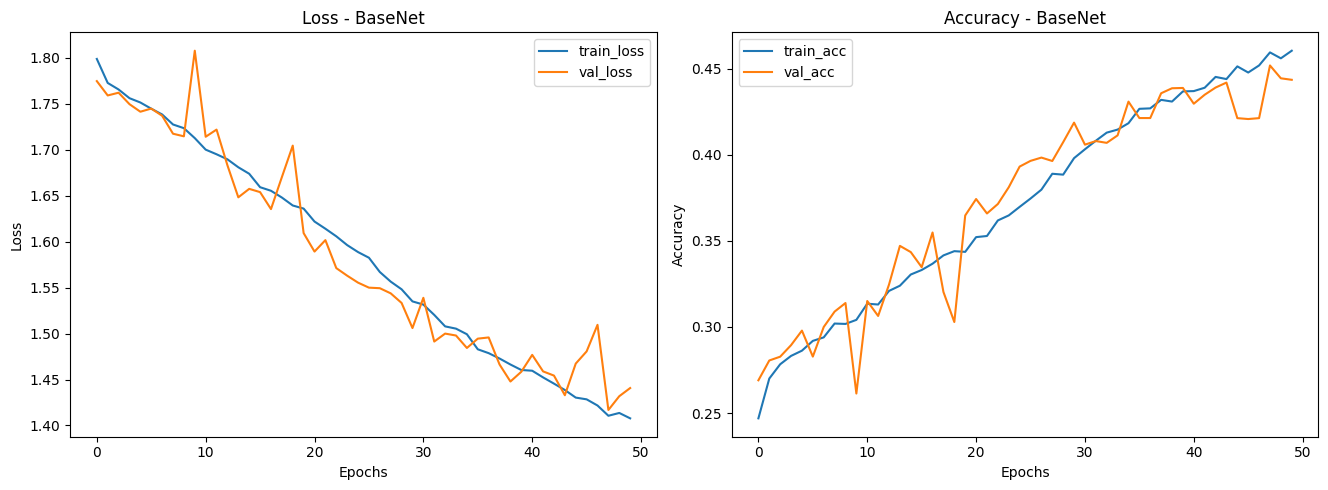

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 178MB/s]


Created EfficientNet-B0 with 5,288,548 parameters

[INFO] Experiment number: 2
[INFO] Testing Optimizer: EfficientNet-B0
------------------------------------------------------------
Created SummaryWriter: saving to: runs/2025-10-02/Pretrained_compare_EfficientNet-B0/EfficientNet-B0
Epoch 1/50 | Loss: 1.3355 | Acc: 52.74% | Val Loss: 1.0019 | Val Acc: 62.34% |
Epoch 2/50 | Loss: 0.9600 | Acc: 64.27% | Val Loss: 0.9210 | Val Acc: 66.19% |
Epoch 3/50 | Loss: 0.8241 | Acc: 69.26% | Val Loss: 0.9959 | Val Acc: 65.98% |
Epoch 4/50 | Loss: 0.6919 | Acc: 74.46% | Val Loss: 0.9478 | Val Acc: 67.14% |
Epoch 5/50 | Loss: 0.5687 | Acc: 78.82% | Val Loss: 1.0327 | Val Acc: 66.73% |
Epoch 6/50 | Loss: 0.4449 | Acc: 83.56% | Val Loss: 1.1029 | Val Acc: 65.57% |
Epoch 7/50 | Loss: 0.3556 | Acc: 87.13% | Val Loss: 1.2532 | Val Acc: 66.51% |
Epoch 8/50 | Loss: 0.2812 | Acc: 90.13% | Val Loss: 1.3464 | Val Acc: 66.11% |
Epoch 9/50 | Loss: 0.2428 | Acc: 91.28% | Val Loss: 1.3819 | Val Acc: 65.63% |
Epoch 

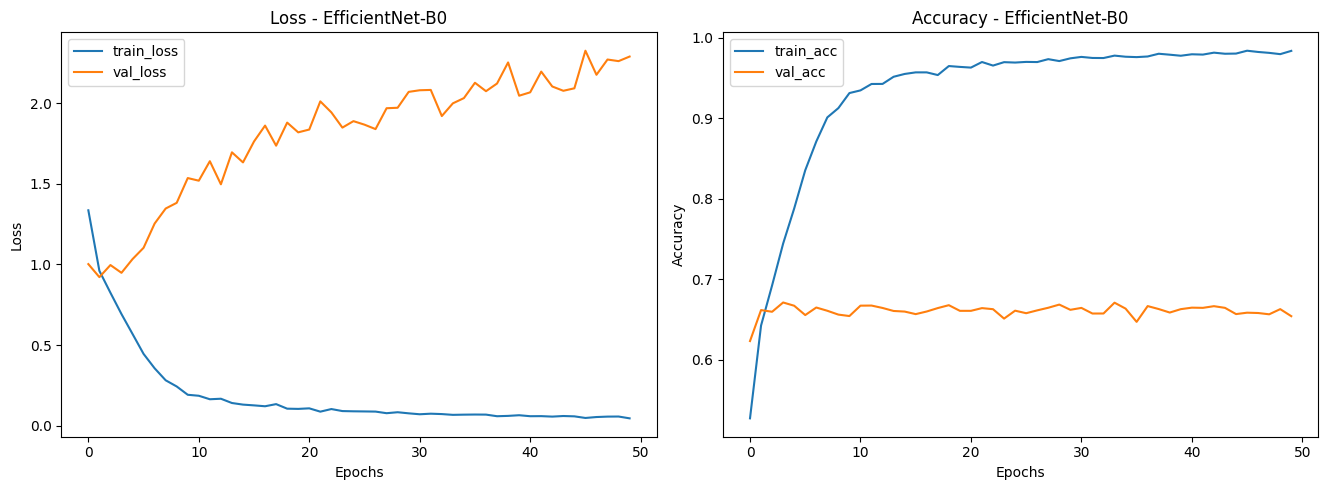

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]

Created ResNet18 with 11,180,103 parameters

[INFO] Experiment number: 3
[INFO] Testing Optimizer: ResNet18
------------------------------------------------------------
Created SummaryWriter: saving to: runs/2025-10-02/Pretrained_compare_ResNet18/ResNet18


Epoch 1/50 | Loss: 1.2166 | Acc: 54.11% | Val Loss: 1.0816 | Val Acc: 59.07% |
Epoch 2/50 | Loss: 1.0017 | Acc: 62.73% | Val Loss: 1.0262 | Val Acc: 61.34% |
Epoch 3/50 | Loss: 0.8811 | Acc: 66.90% | Val Loss: 0.9956 | Val Acc: 63.06% |
Epoch 4/50 | Loss: 0.7421 | Acc: 72.55% | Val Loss: 0.9884 | Val Acc: 64.58% |
Epoch 5/50 | Loss: 0.5698 | Acc: 79.01% | Val Loss: 1.0884 | Val Acc: 62.75% |
Epoch 6/50 | Loss: 0.3825 | Acc: 86.41% | Val Loss: 1.3523 | Val Acc: 63.06% |
Epoch 7/50 | Loss: 0.2565 | Acc: 90.87% | Val Loss: 1.4580 | Val Acc: 63.18% |
Epoch 8/50 | Loss: 0.1634 | Acc: 94.41% | Val Loss: 1.5473 | Val Acc: 64.28% |
Epoch 9/50 | Loss: 0.1476 | Acc: 94.98% | Val Loss: 1.6299 | Val Acc: 63.48% |
Epoch 10/50 | Loss: 0.1157 | Acc: 96.16% | Val Loss: 1.8208 | Val Acc: 62.63% |
Epoch 11/50 | Loss: 0.1002 | Acc: 96.73% | Val Loss: 1.9499 | Val Acc: 62.89% |
Epoch 12/50 | Loss: 0.1007 | Acc: 96.64% | Val Loss: 2.0364 | Val Acc: 63.77% |
Epoch 13/50 | Loss: 0.0899 | Acc: 97.02% | Val Lo

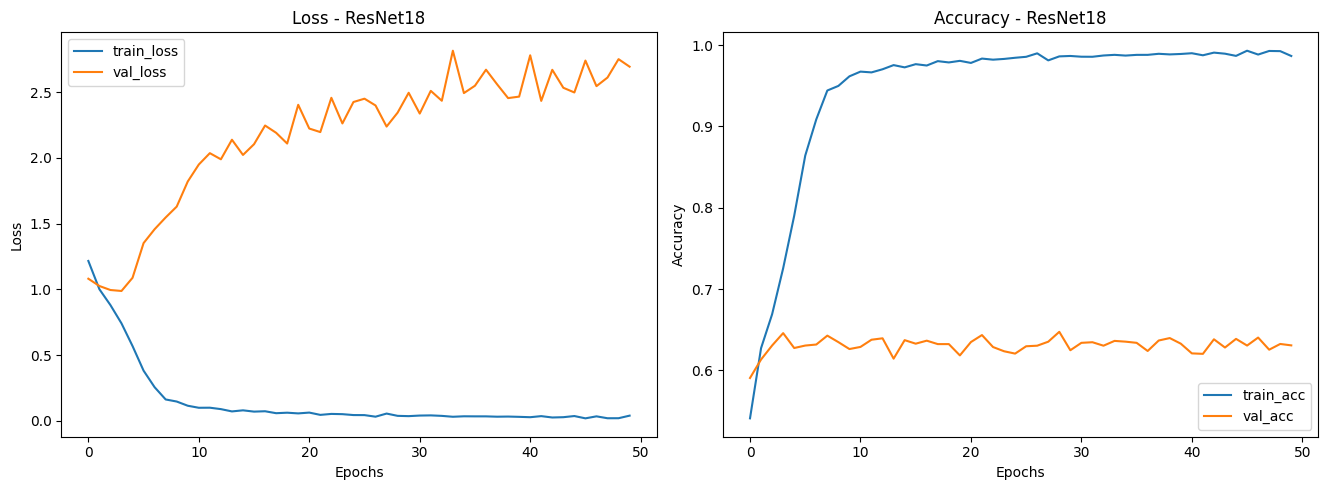

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 203MB/s]


Created ViT-B/16 with 86,567,656 parameters

[INFO] Experiment number: 4
[INFO] Testing Optimizer: ViT-B/16
------------------------------------------------------------
Created SummaryWriter: saving to: runs/2025-10-02/Pretrained_compare_ViT-B/16/ViT-B/16
Epoch 1/50 | Loss: 1.8458 | Acc: 23.05% | Val Loss: 1.8173 | Val Acc: 24.79% |
Epoch 2/50 | Loss: 1.8026 | Acc: 24.25% | Val Loss: 1.8371 | Val Acc: 17.79% |
Epoch 3/50 | Loss: 1.7886 | Acc: 25.08% | Val Loss: 1.7866 | Val Acc: 24.42% |
Epoch 4/50 | Loss: 1.7779 | Acc: 26.31% | Val Loss: 1.7675 | Val Acc: 26.61% |
Epoch 5/50 | Loss: 1.7661 | Acc: 26.98% | Val Loss: 1.7780 | Val Acc: 27.01% |
Epoch 6/50 | Loss: 1.7523 | Acc: 27.88% | Val Loss: 1.7464 | Val Acc: 27.74% |
Epoch 7/50 | Loss: 1.7344 | Acc: 29.00% | Val Loss: 1.7388 | Val Acc: 29.12% |
Epoch 8/50 | Loss: 1.7146 | Acc: 30.41% | Val Loss: 1.7051 | Val Acc: 31.24% |
Epoch 9/50 | Loss: 1.6907 | Acc: 31.92% | Val Loss: 1.7027 | Val Acc: 31.77% |
Epoch 10/50 | Loss: 1.6757 | Acc:

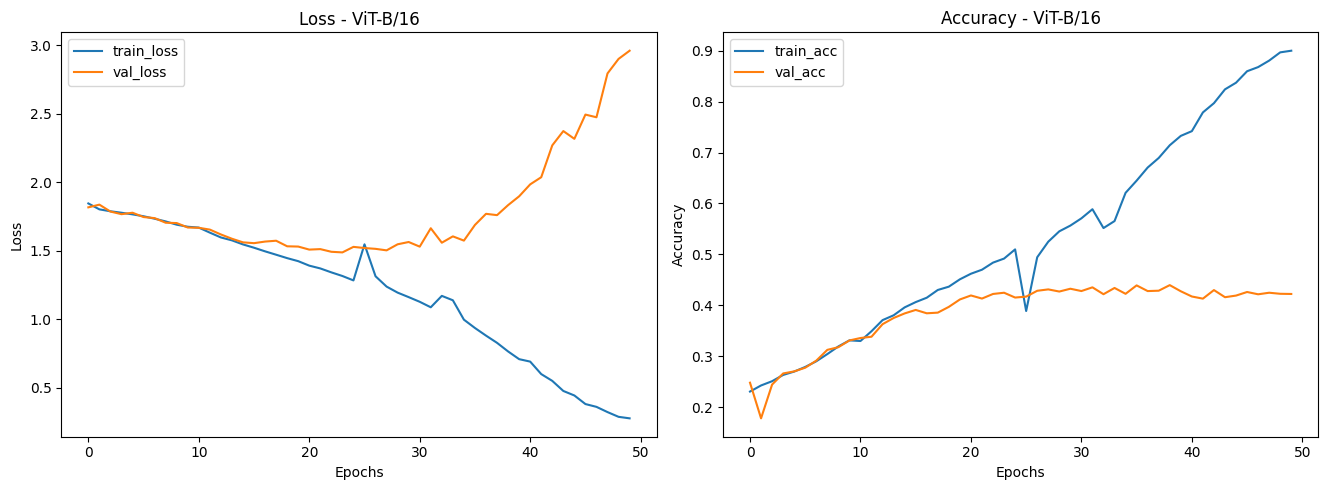

In [8]:
set_seed()
lr = 5.25e-4
epochs = 50

models_to_train = ['BaseNet', 'EfficientNet-B0', 'ResNet18', 'ViT-B/16']

experiment_number = 0
final_results = {}
for obj_name in models_to_train:
    # Create new model and optimizer for each experiment
    model = create_model(obj_name, len(class_names), device)
    print(f"Created {obj_name} with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()
    
    experiment_number += 1
    print(f"\n[INFO] Experiment number: {experiment_number}")
    print(f"[INFO] Testing Optimizer: {obj_name}")
    print('-' * 60)
    
    results = train(model, train_dl, val_dl, optimizer, loss_fn, epochs, device,
                    writer=create_writer(exp_name=f"Pretrained_compare_{obj_name}", model_name=obj_name))

    final_results[obj_name] = {
        'model':model,
        'train_results': results,
        'best_val_acc': max(results['val_acc']),
        'final_val_acc': results['val_acc'][-1],
        'final_val_loss': results['val_loss'][-1],
    }
    
    # Plot results for this experiment
    train_loss = results['train_loss']
    train_acc = results['train_acc']
    val_loss = results['val_loss']
    val_acc = results['val_acc']
    
    epochs_ = range(len(train_loss))
    plt.figure(figsize=(20, 5))
    
    # Subplot 1: Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs_, train_loss, label='train_loss')
    plt.plot(epochs_, val_loss, label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss - {obj_name}')
    plt.legend()
    
    # Subplot 2: Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs_, train_acc, label='train_acc')
    plt.plot(epochs_, val_acc, label='val_acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy - {obj_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    print('=' * 80 + '\n')


In [9]:
# Create timestamped filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
zip_name = f"tensorboard_logs_{timestamp}"

# Compress
shutil.make_archive(zip_name, 'zip', "runs")
print(f"✓ Download {zip_name}.zip from Output tab")

✓ Download tensorboard_logs_20251002_1502.zip from Output tab


## -- EVALUATION ON TEST DATA --

📊 FINAL MODEL EVALUATION

Evaluating BaseNet...


<Figure size 800x600 with 0 Axes>

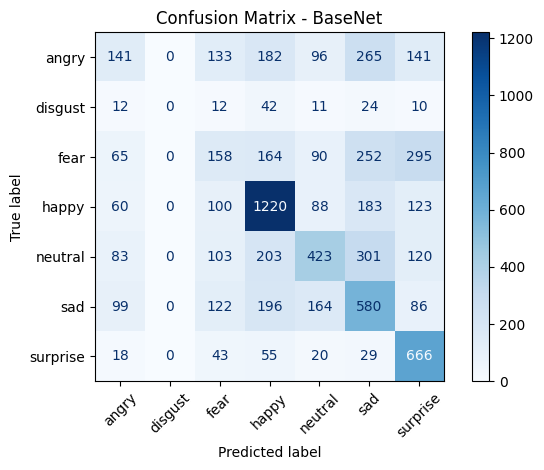

✅ Test Accuracy: 44.55% | F1: 0.3437

Evaluating EfficientNet-B0...


<Figure size 800x600 with 0 Axes>

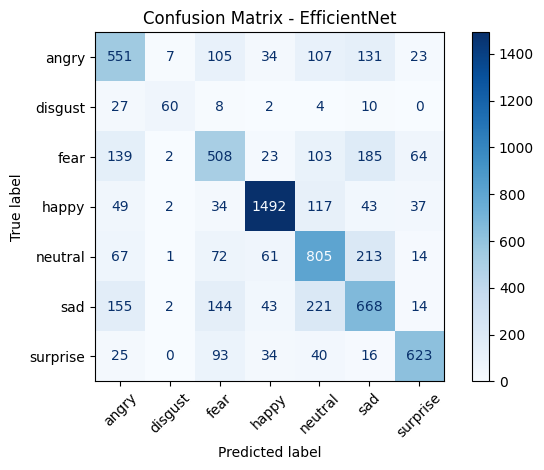

✅ Test Accuracy: 65.62% | F1: 0.6429

Evaluating ResNet18...


<Figure size 800x600 with 0 Axes>

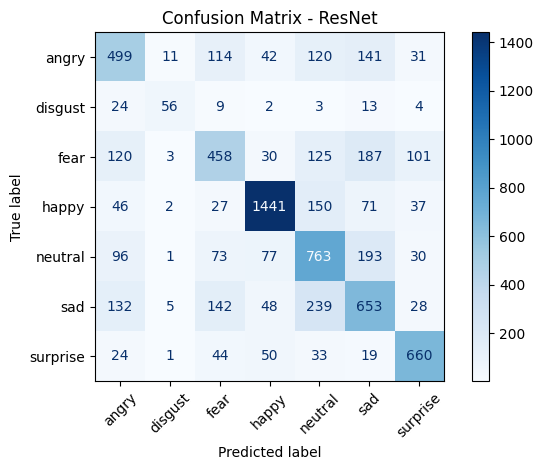

✅ Test Accuracy: 63.19% | F1: 0.6125

Evaluating ViT-B/16...


<Figure size 800x600 with 0 Axes>

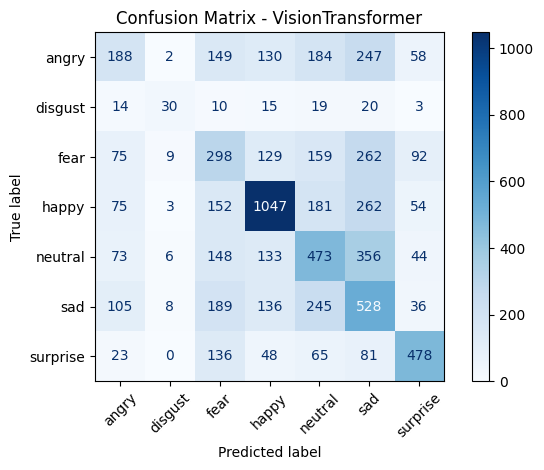

✅ Test Accuracy: 42.40% | F1: 0.4030

RESULTS SUMMARY
          Model Val Acc (%) Test Acc (%) Test F1
        BaseNet       45.19        44.55  0.3437
EfficientNet-B0       67.14        65.62  0.6429
       ResNet18       64.74        63.19  0.6125
       ViT-B/16       43.96        42.40  0.4030

BEST MODEL
🏆 EfficientNet-B0: 65.62% accuracy


In [10]:
set_seed()
def comprehensive_evaluation(model, test_dl, loss_fn, class_names, device):
    """All-in-one evaluation with metrics and visualization"""
    model.eval()
    test_loss, test_acc = 0, 0
    y_true, y_pred = [], []
    
    with torch.inference_mode():
        for X, y in test_dl:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            test_loss += loss.item()
            
            preds = outputs.argmax(dim=1)
            test_acc += (preds == y).sum().item() / len(preds)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    # Calculate metrics
    avg_loss = test_loss / len(test_dl)
    avg_acc = test_acc / len(test_dl)
    test_f1 = f1_score(y_true, y_pred, average='macro')
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues')
    plt.xticks(rotation=45)
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.tight_layout()
    plt.show();
    
    return avg_loss, avg_acc, test_f1

# Section 1: Evaluate all models and store results
print("📊 FINAL MODEL EVALUATION")
print("=" * 50)

test_results = {}
for model_name, result in final_results.items():
    print(f"\nEvaluating {model_name}...")
    test_loss, test_acc, test_f1 = comprehensive_evaluation(
        result['model'], test_dl, loss_fn, class_names, device
    )
    test_results[model_name] = {
        'test_acc': test_acc, 
        'test_f1': test_f1,
        'val_acc': result['best_val_acc']
    }
    print(f"✅ Test Accuracy: {test_acc*100:.2f}% | F1: {test_f1:.4f}")

# Section 2: Create summary table
print(f"\n{'='*60}")
print("RESULTS SUMMARY")
print(f"{'='*60}")

summary_data = []
for model_name, metrics in test_results.items():
    summary_data.append({
        'Model': model_name,
        'Val Acc (%)': f"{metrics['val_acc']*100:.2f}",
        'Test Acc (%)': f"{metrics['test_acc']*100:.2f}", 
        'Test F1': f"{metrics['test_f1']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Section 3: Best model identification
print(f"\n{'='*40}")
print("BEST MODEL")
print(f"{'='*40}")

best_model = max(test_results.items(), key=lambda x: x[1]['test_acc'])
print(f"🏆 {best_model[0]}: {best_model[1]['test_acc']*100:.2f}% accuracy")